In [1]:
import numpy as np
from scipy.spatial import KDTree
import os
import h5py
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from tqdm import tqdm
import cartopy

In [2]:
#model_root_dir = r'Z:\cluster_projects\ro\1149_10\earthformer-multisource-to-inca\experiments_adapted129\repotest\testOutput'
model_root_dir = r'D:\Ghana\Output_data\experiments_adapted131\repotest\testOutput'

In [3]:
#dt_list = np.empty(len(os.listdir(model_root_dir)), dtype=object)
#target_station_cells = np.zeros((len(os.listdir(model_root_dir)), len(station_name_list)))
#pred_station_cells = np.zeros((len(os.listdir(model_root_dir)), len(station_name_list)))

squared_error = np.zeros((248, 184))
count = 0

# Wrap the loop with tqdm for progress bar
for i, file in enumerate(tqdm(os.listdir(model_root_dir), desc="Processing files")):
    try:
        time_str = file.split('_')[1].split('.')[0]
        # Rearrange timestamp to match nearest timestamp of GMET stations (adjust as needed)
        #dt_list[i] = datetime.strptime(time_str, "%Y%m%d%H%M%S") + timedelta(seconds=1)
        with h5py.File(fr'{model_root_dir}//{file}', 'r') as f:
            # Convert from mm/h to mm/30 min
            target = np.flipud(np.squeeze(f['y'][:]))
            pred = np.flipud(np.squeeze(f['y_hat'][:]))

                        # Ensure the target and prediction values don't have NaNs
            if not np.isnan(target).any() and not np.isnan(pred).any():
                squared_error += ((target - pred) ** 2)
                count += 1
            else:
                print(f"NaN values detected in file {file}")

    
    except Exception as e:
        print(f"Error occurred while processing file {file}: {e}")
        

Processing files: 100%|█████████████████████████████████████████████████████████████| 728/728 [00:01<00:00, 695.86it/s]


In [4]:
RMSE = np.sqrt(squared_error / count)

In [5]:
with h5py.File('RMSE_balanced_loss.h5', 'w') as f:
    f.create_dataset('RMSE', data=RMSE)

In [3]:
grid_path = r'Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/data_adapted_condition_0.02_20_all/Aux/grid_2d_wgs84.h5'
rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='10m')
border = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
lon_model = h5py.File(grid_path,'r')['lon'][:, :]
lat_model = h5py.File(grid_path,'r')['lat'][:, :]

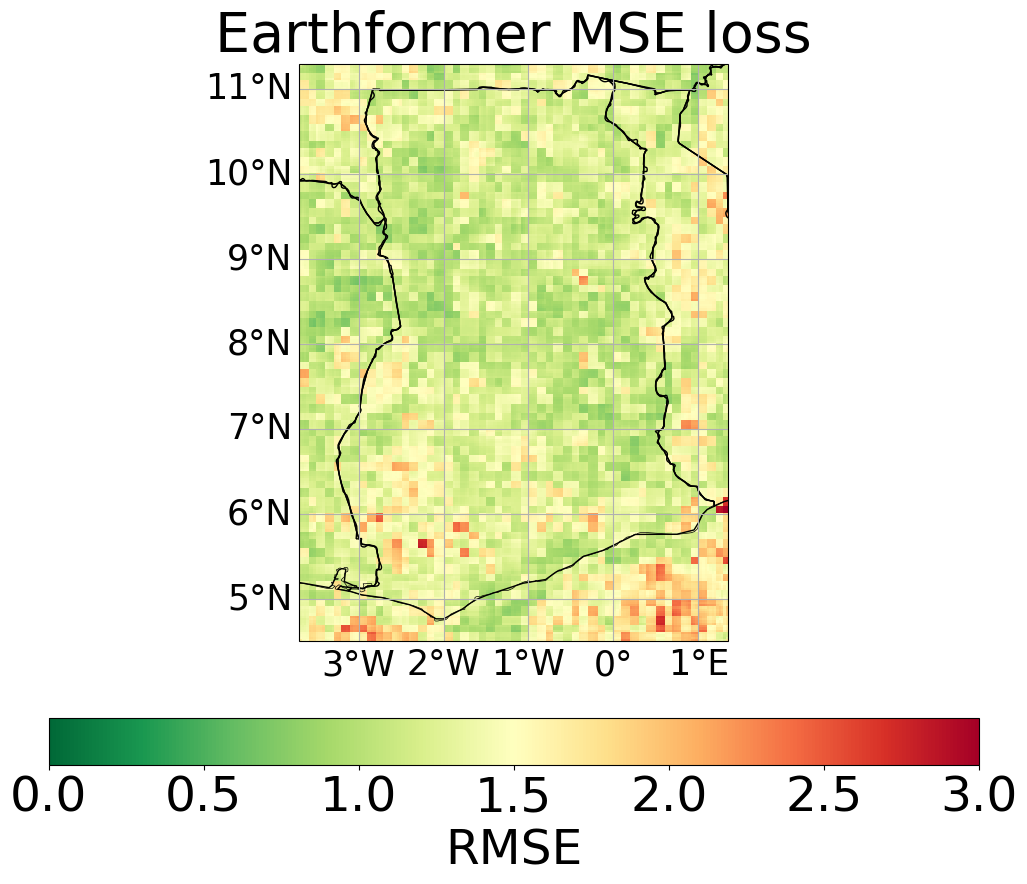

In [11]:
# Load the SEVIRI file to get longitude latitude grid
file_path = r"RMSE_MSE_loss.h5"

ds = xr.open_dataset(file_path, engine = 'netcdf4')    


# plt.figure(figsize=(9, 10))
# ds['y_hat'].plot(cmap=custom_cmap, norm=custom_norm)

# # Create the plot
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.title('Earthformer MSE loss', fontsize = 40)

# Plot the SEVIRI data
data = ds['RMSE'][:] # Replace 'y_hat' with the actual variable name in your dataset
data = np.squeeze(data) #np.flipud?
mesh = ax.pcolormesh(lon_model, lat_model, data, cmap='RdYlGn_r', vmin=0., vmax=3, transform=ccrs.PlateCarree())

# Add borders, rivers, and coastlines
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m'),
               edgecolor='black', facecolor='none')
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m'),
#                edgecolor='blue', facecolor='none', linewidth=0.5)

# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# Customize gridline label font size and padding
gl.xlabel_style = {'size': 25, 'rotation': 0}  # Longitude label style
gl.ylabel_style = {'size': 25, 'rotation': 0}  # Latitude label style

# Add and customize colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('RMSE', fontsize=35)
cbar.ax.tick_params(labelsize=35)  # Adjust tick label size

# # Add a colorbar
# cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05)
# cbar.set_label('RMSE')  # Replace with appropriate label

plt.savefig('RMSE_MSE_loss.png', dpi = 300)

# Show the plot
#plt.title('SEVIRI Data with Borders and Rivers')
plt.show()

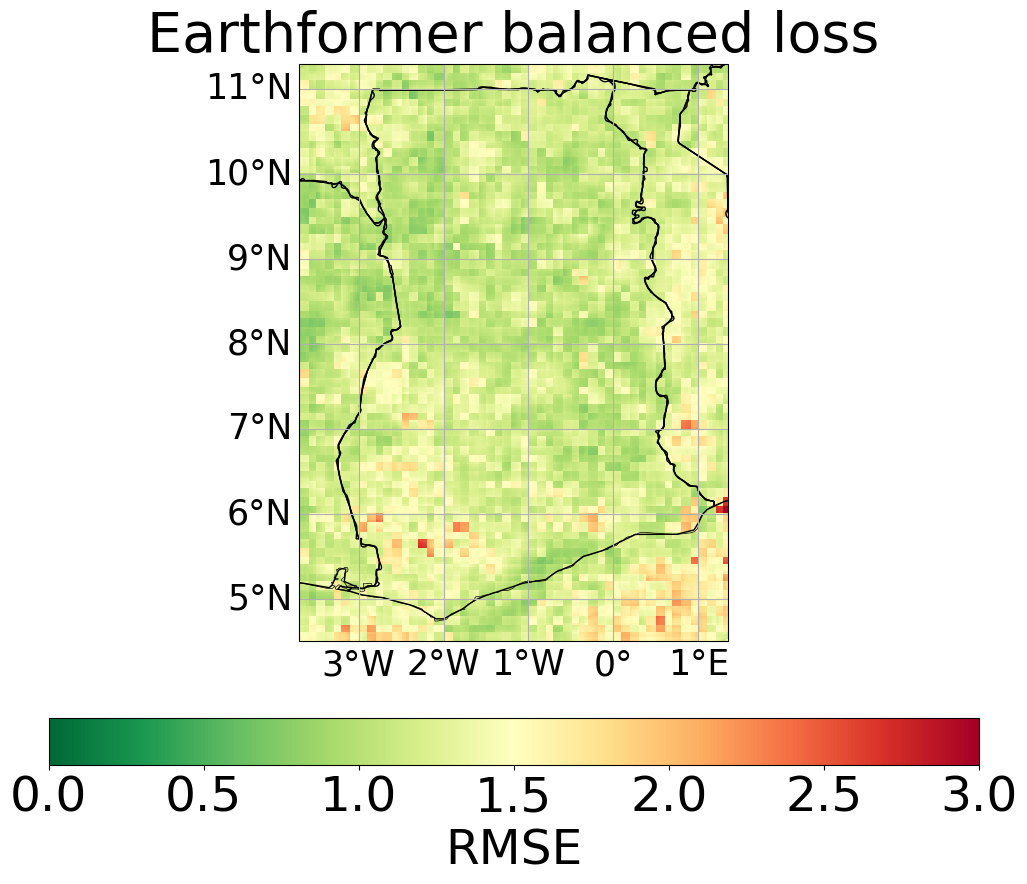

In [10]:
# Load the SEVIRI file to get longitude latitude grid
file_path = r"RMSE_balanced_loss.h5"

ds = xr.open_dataset(file_path, engine = 'netcdf4')    


# plt.figure(figsize=(9, 10))
# ds['y_hat'].plot(cmap=custom_cmap, norm=custom_norm)

# # Create the plot
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title('Earthformer balanced loss', fontsize = 40)

# Plot the SEVIRI data
data = ds['RMSE'][:] # Replace 'y_hat' with the actual variable name in your dataset
data = np.squeeze(data) #np.flipud?
mesh = ax.pcolormesh(lon_model, lat_model, data, vmin=0., vmax=3, cmap='RdYlGn_r', transform=ccrs.PlateCarree())

# Add borders, rivers, and coastlines
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m'),
               edgecolor='black', facecolor='none')
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m'),
#                edgecolor='blue', facecolor='none', linewidth=0.5)

# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# Customize gridline label font size and padding
gl.xlabel_style = {'size': 25, 'rotation': 0}  # Longitude label style
gl.ylabel_style = {'size': 25, 'rotation': 0}  # Latitude label style

# Add and customize colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('RMSE', fontsize=35)
cbar.ax.tick_params(labelsize=35)  # Adjust tick label size

# # Add a colorbar
# cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05)
# cbar.set_label('RMSE')  # Replace with appropriate label

plt.savefig('RMSE_balanced_loss.png', dpi = 300)
# Show the plot
#plt.title('SEVIRI Data with Borders and Rivers')
plt.show()